In [1]:
import pandas as pd

import torch
from sklearn.model_selection import train_test_split
from transformers import RobertaForSequenceClassification, RobertaTokenizer, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, classification_report

C:\Users\Kuba\Documents\py_interpreter2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_data = pd.read_csv("data/subtask-2-arabic/train_ar.tsv",sep='\t')
dev_data = pd.read_csv("data/subtask-2-arabic/dev_ar.tsv", sep='\t')


In [3]:
# Mapping label strings to integers
label_map = {"OBJ": 0, "SUBJ": 1}
train_data['label'] = train_data['label'].map(label_map)
print(train_data['label'])

dev_data['label'] = dev_data['label'].map(label_map)
print(dev_data['label'])

0       0
1       0
2       0
3       0
4       1
       ..
1180    1
1181    0
1182    1
1183    0
1184    0
Name: label, Length: 1185, dtype: int64
0      0
1      0
2      0
3      1
4      0
      ..
292    0
293    0
294    0
295    0
296    0
Name: label, Length: 297, dtype: int64


In [4]:
#train_data = train_data.drop('solved_conflict', axis=1)

In [5]:
train_data

,sentence_id,sentence,label
0,MIS_702-curl_03_010,"وحتى الآن هذا العام، كانت الشمس ""فارغة"" مع عدم...",0
1,MIS_560-curl_04_005,وكان أفيخاي قد نشر تدوينة بشأن مسلسل النهاية ق...,0
2,MIS_2265-eurl_03_022,وجاء في خطاب ممثل بوليساريو أحمد بخاري يوم الا...,0
3,FAT_1139-eurl_01_023,4 أسئلة ينبغي طرحها قبل تصديق المعلومة,0
4,MIS_427-curl_06_004,وذكر مجاهد أن الوزيرة محملة خلال تلك الزيارة ب...,1
...,...,...,...
1180,MIS_366-curl_03_007,فارقتنا ولا زالت روحها ترفرف على مآسي البؤساء ...,1
1181,FAT_1352-curl_03_002,تلقي اللواء إيهاب لمعى، حكمدار الجنوب بمديرية ...,0
1182,MIS_238-curl_02_003,"وتابع التقرير: ""المصادر قالت إنها تحدثت مع أحد...",1
1183,AFP_458-eurl_02_005,كان بطل فقرة بروباغندا في الحلقة الأولى هو صلا...,0


In [6]:
# Load tokenizer
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification, Trainer, TrainingArguments
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-large')

In [7]:
train_encodings = tokenizer(train_data['sentence'].tolist(), truncation=True, padding=True)
eval_encodings = tokenizer(dev_data['sentence'].tolist(), truncation=True, padding=True)

In [8]:
#train_encodings["input_ids"]
#train_encodings["attention_mask"]


In [9]:
# Create PyTorch datasets
train_dataset = torch.utils.data.TensorDataset(
    torch.tensor(train_encodings['input_ids']),
    torch.tensor(train_encodings['attention_mask']),
    torch.tensor(train_data['label'])
)

val_dataset = torch.utils.data.TensorDataset(
    torch.tensor(eval_encodings['input_ids']),
    torch.tensor(eval_encodings['attention_mask']),
    torch.tensor(dev_data['label'])
)

In [10]:
print(train_dataset[0][0].shape) # input_ids shape
print(train_dataset[0][1].shape) # attention_mask shape
print(train_dataset[0][2].shape) # train_labels_onehot shape

torch.Size([269])
torch.Size([269])
torch.Size([])


In [11]:
# Define model
model = XLMRobertaForSequenceClassification.from_pretrained('xlm-roberta-large', num_labels=2)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
# trainer parameters
epochs = 3
learning_rate=5e-5

In [13]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=epochs,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy='steps',
    eval_steps=25,
    learning_rate=learning_rate,
)

In [14]:
# Define the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=lambda data: {'input_ids': torch.stack([item[0] for item in data]),
                                'attention_mask': torch.stack([item[1] for item in data]),
                                'labels': torch.stack([item[2] for item in data])},
)

C:\Users\Kuba\Documents\py_interpreter2\Lib\site-packages\accelerate\accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [15]:
# Train the model
trainer.train()

# epoch 3 / 50

# epoch 4 / 25
#Step	Training Loss	Validation Loss
#25	0.669400	0.597859
#50	0.541100	0.535363
#75	0.538000	0.617245
#100	0.506300	0.530148
#125	0.507400	0.658192
#150	0.508700	0.382725
#175	0.479700	0.433021
#200	0.397700	0.336382
#225	0.419200	0.653025
#250	0.271400	0.703168
#275	0.334100	0.588781
#300	0.436000	0.564848


Step,Training Loss,Validation Loss
25,0.679200,0.585408
50,0.553000,0.536443
75,0.555900,0.645571
100,0.518700,0.533964
125,0.525800,0.506026
150,0.472500,0.350239
175,0.397200,0.340754
200,0.483000,0.386665
225,0.426600,0.371278


TrainOutput(global_step=225, training_loss=0.5063517814212375, metrics={'train_runtime': 5811.6329, 'train_samples_per_second': 0.612, 'train_steps_per_second': 0.039, 'total_flos': 1740627545104980.0, 'train_loss': 0.5063517814212375, 'epoch': 3.0})

In [16]:
#model.save_pretrained("./model")

In [17]:
#model = XLMRobertaForSequenceClassification.from_pretrained("./model")

In [18]:
# test
test_data = pd.read_csv("data/subtask-2-arabic/dev_test_ar.tsv", sep='\t')  # Update with your dev data file
test_data['label'] = test_data['label'].map(label_map)
test_encodings = tokenizer(test_data['sentence'].tolist(), truncation=True, padding=True)

test_dataset = torch.utils.data.TensorDataset(
    torch.tensor(test_encodings['input_ids']),
    torch.tensor(test_encodings['attention_mask']),
    torch.tensor(test_data['label'])
)

In [19]:
preds = trainer.predict(test_dataset)
pred_labels = preds.predictions.argmax(-1)



In [20]:
print(pred_labels)

[1 0 0 1 1 1 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 1 1 0
 0 0 0 0 1 0 1 1 0 0 1 1 0 0 0 1 0 1 0 1 0 1 0 0 0 1 1 0 0 0 0 1 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1 1 1 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0
 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 1 1 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0
 1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0
 0 0 0 1 0 1 0 0 1 1 0 0 1 0 0 0 1 0 0 0 1 1 0 0 1 1 0 0 0 1 0 0 1 1 0 1 1
 0 0 0 1 1 0 0 0 0 1 1 0 0 1 0 1 0 0 1 0 0 0 0 1 1 0 0 1 0 0 0 1 0 1 1 0 0
 1 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0
 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 1 1 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0
 1 0 1 0 1 1 1 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 0 1 1 0 1 1 0 0 1 1 1 0 1 0 0 1 0 0 1 0 0 0 0 0 1 1 1 0 0 0 1 0 0 0
 1]


In [21]:
# Convert the true labels to integers

# Compute the accuracy and classification report
accuracy = accuracy_score(test_data['label'], pred_labels)
class_report = classification_report(test_data['label'], pred_labels, target_names=['OBJ', 'SUBJ'])

print(f"Accuracy for RoBERTa: {accuracy}")
print(f"Classification Report:\n{class_report}")

Accuracy for RoBERTa: 0.8044943820224719
Classification Report:
              precision    recall  f1-score   support

         OBJ       0.94      0.81      0.87       363
        SUBJ       0.48      0.78      0.60        82

    accuracy                           0.80       445
   macro avg       0.71      0.80      0.73       445
weighted avg       0.86      0.80      0.82       445



In [22]:
# epochs 3 - acc 0.78 - OBJ 0.95, SUBJ 0.45, recall 0.77 - 0.83, f1 0.85 - 0.59
# epochs 4 - acc 0.84 - OBJ 0.84, SUBJ 0.70, recall 0.98 - 0.20, f1 0.91 - 0.30

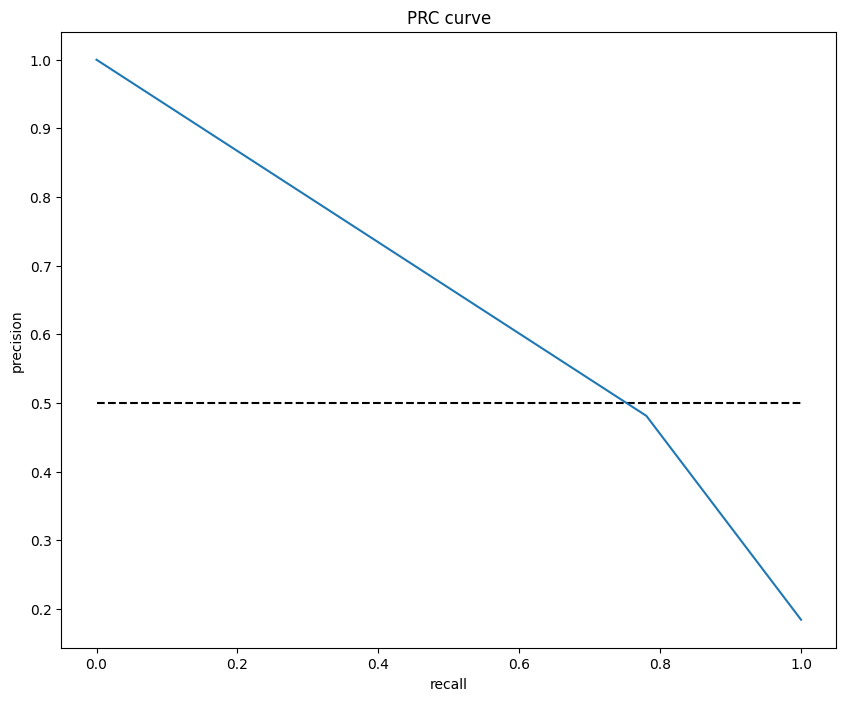

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(test_data['label'], pred_labels)
plt.figure(figsize = (10,8))
plt.plot([0, 1], [0.5, 0.5],'k--')
plt.plot(recall, precision, label = 'Knn')
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('PRC curve')
plt.show()